In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau

from datetime import date

print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

import configparser
config = configparser.ConfigParser()
config.read('config.ini')

import wandb
wandb.login()

2.9.2
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: mato-katkovcin (nsiete-hrnciar-katkovcin). Use `wandb login --relogin` to force relogin


True

In [2]:
name_of_run = 'wider-conv-layers-3-image-generator-batchNormalization'

In [3]:
run = wandb.init(project="convolutional-nn", id=name_of_run)

In [4]:
EPOCHS = config['default'].getint('epochs')
IMAGE_SIZE = config['default'].getint('image_size')
BATCH_SIZE = config['default'].getint('batch_size')
SEED = config['default'].getint('seed')
START_LR = config['default'].getfloat('start_lr')
MAX_LR = config['default'].getfloat('max_lr')
STEPS_PER_EPOCH = config['default'].getint('steps_per_epoch')
ANNEAL_STRATEGY = config['default']['strategy']

wandb.config.update({'epochs': EPOCHS, 
                     'image_size': IMAGE_SIZE, 
                     'batch_size': BATCH_SIZE,
                     'start_lr': START_LR,
                     'max_lr': MAX_LR, 
                     'strategy': ANNEAL_STRATEGY})

In [5]:
data_path = 'Data/original'

class_names = sorted(os.listdir(data_path))
num_classes = len(class_names)
print("Number of Classes:", num_classes)

class_sizes = []
for name in class_names:
    class_size = len(os.listdir(data_path + "/" + name))
    class_sizes.append(class_size)

print("Class Distribution:\n", dict(zip(class_names, class_sizes)))

Number of Classes: 10
Class Distribution:
 {'butterfly': 2112, 'cat': 1668, 'chicken': 3098, 'cow': 1866, 'dog': 4863, 'elephant': 1446, 'horse': 2623, 'sheep': 1820, 'spider': 4821, 'squirrel': 1862}


In [6]:
distribution = dict(zip(class_names, class_sizes))
distributionDf = pd.DataFrame.from_dict(distribution.items())
distributionDf.columns = ['Animal', 'Count']
distributionDf = distributionDf.reset_index()
distributionDf

,index,Animal,Count
0,0,butterfly,2112
1,1,cat,1668
2,2,chicken,3098
3,3,cow,1866
4,4,dog,4863
5,5,elephant,1446
6,6,horse,2623
7,7,sheep,1820
8,8,spider,4821
9,9,squirrel,1862


<AxesSubplot:title={'center':'Animal class distribution'}, ylabel='Animal'>

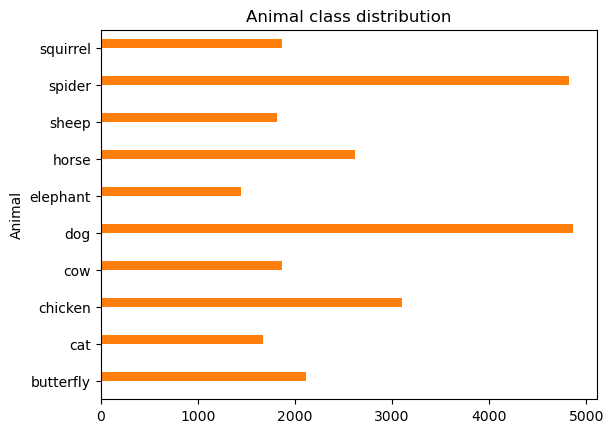

In [7]:
distributionDf.plot.barh(x = 'Animal', title='Animal class distribution', legend = False)

In [8]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  'Data/original',
  validation_split=0.2,
  subset="training",
  seed=SEED,
  image_size=(IMAGE_SIZE, IMAGE_SIZE),
  batch_size=BATCH_SIZE)

val_ds = tf.keras.utils.image_dataset_from_directory(
  'Data/original',
  validation_split=0.2,
  subset="validation",
  seed=SEED,
  image_size=(IMAGE_SIZE, IMAGE_SIZE),
  batch_size=BATCH_SIZE)

Found 26179 files belonging to 10 classes.
Using 20944 files for training.
Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-04-06 16:22:20.700054: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-06 16:22:20.700192: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 26179 files belonging to 10 classes.
Using 5235 files for validation.


2023-04-06 16:22:21.771037: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


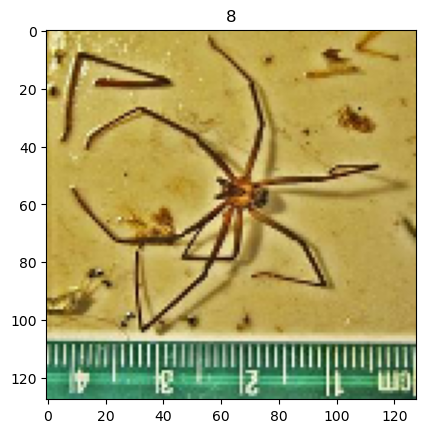

In [9]:
for images, labels in train_ds.take(1):
    plt.imshow(images[0].numpy().astype('uint8'))
    plt.title(labels[0].numpy())
    break

In [10]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 128, 128, 3)
(32,)


In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [12]:
train_datagen =  tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
                  'Data/original',
                  target_size=(IMAGE_SIZE, IMAGE_SIZE),
                  batch_size=BATCH_SIZE,
                  shuffle=True,
                  subset='training',
                  class_mode='binary')

val_generator = train_datagen.flow_from_directory(
                  'Data/original',
                  target_size=(IMAGE_SIZE, IMAGE_SIZE),
                  batch_size=BATCH_SIZE,
                  shuffle=True,
                  subset='validation',
                  class_mode='binary')   

Found 20947 images belonging to 10 classes.
Found 5232 images belonging to 10 classes.


In [13]:
def schedule(epoch):
    cycle = 0
    if epoch < (EPOCHS // 2):
        cycle = 1 + (epoch * STEPS_PER_EPOCH) // (EPOCHS // 2)
        factor = float(cycle * MAX_LR) / float(EPOCHS)
    else:
        cycle = 1 + ((EPOCHS - epoch) * STEPS_PER_EPOCH) // (EPOCHS // 2)
        factor = float(cycle * MAX_LR) / float(EPOCHS)
        factor = MAX_LR - factor

    if ANNEAL_STRATEGY == 'cos':
        lr = factor * (1 + tf.math.cos(tf.constant(np.pi) * (epoch % (EPOCHS // 2)) / (EPOCHS // 2))) / 2
    elif ANNEAL_STRATEGY == 'linear':
        lr = factor * (EPOCHS - epoch) / EPOCHS
    else:
        raise ValueError('Invalid anneal strategy')

    return lr

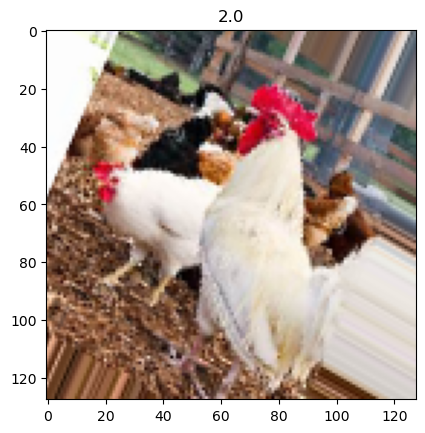

In [14]:
for images, labels in iter(train_generator):
    plt.imshow(images[0])
    plt.title(labels[0])
    break

In [15]:
class WandbCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        wandb.log(logs)

In [16]:
""" with tf.device('/cpu:0'):
  augment = tf.keras.Sequential([
      layers.Rescaling(1./255, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
      layers.RandomFlip("horizontal_and_vertical"),
      layers.RandomRotation(0.2)
  ]) """

model = tf.keras.Sequential([
    #augment,

    layers.Conv2D(32, 3, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(128, 3, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Activation('relu'),
    layers.Dense(10)
])

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()
#lr_scheduler = LearningRateScheduler(schedule=schedule, verbose=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, min_lr=0.0001)

metrics = [
    tf.keras.metrics.SparseCategoricalAccuracy(),
    tf.keras.metrics.SparseCategoricalCrossentropy(from_logits=True)
]

model.compile(loss=loss_fn, optimizer=optimizer, metrics=metrics)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 32)     128       
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 128, 128, 16)      528       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        9280      
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 64)       2

In [17]:
callbacks = [WandbCallback(), 
             EarlyStopping(monitor='val_sparse_categorical_accuracy', patience = 3, restore_best_weights=True), 
             ModelCheckpoint("model_checkpoint.h5", save_best_only=True), 
             reduce_lr]

In [18]:
model.fit(train_generator, validation_data=val_generator, epochs=EPOCHS, callbacks=callbacks)

Epoch 1/10


2023-04-06 16:22:49.427733: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


655/655 [==============================] - ETA: 0s - loss: 1.9590 - sparse_categorical_accuracy: 0.3229 - sparse_categorical_crossentropy: 1.9590

2023-04-06 16:26:18.254453: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


655/655 [==============================] - 228s 344ms/step - loss: 1.9590 - sparse_categorical_accuracy: 0.3229 - sparse_categorical_crossentropy: 1.9590 - val_loss: 1.9707 - val_sparse_categorical_accuracy: 0.3196 - val_sparse_categorical_crossentropy: 1.9707 - lr: 0.0010
Epoch 2/10
655/655 [==============================] - 255s 389ms/step - loss: 1.7151 - sparse_categorical_accuracy: 0.4006 - sparse_categorical_crossentropy: 1.7151 - val_loss: 1.7644 - val_sparse_categorical_accuracy: 0.3857 - val_sparse_categorical_crossentropy: 1.7644 - lr: 0.0010
Epoch 3/10
655/655 [==============================] - 298s 455ms/step - loss: 1.6362 - sparse_categorical_accuracy: 0.4299 - sparse_categorical_crossentropy: 1.6362 - val_loss: 1.7065 - val_sparse_categorical_accuracy: 0.4037 - val_sparse_categorical_crossentropy: 1.7065 - lr: 0.0010
Epoch 4/10
655/655 [==============================] - 1242s 2s/step - loss: 1.5446 - sparse_categorical_accuracy: 0.4654 - sparse_categorical_crossentropy: 

In [19]:
pd.DataFrame(model.history.history)

,loss,sparse_categorical_accuracy,sparse_categorical_crossentropy,val_loss,val_sparse_categorical_accuracy,val_sparse_categorical_crossentropy,lr
0,1.958951,0.322862,1.958951,1.970698,0.319572,1.970698,0.001
1,1.715066,0.400582,1.715066,1.764430,0.385703,1.764430,0.001
2,1.636209,0.429942,1.636209,1.706490,0.403670,1.706490,0.001
3,1.544622,0.465413,1.544622,1.974843,0.387232,1.974843,0.001
4,1.485914,0.486752,1.485914,2.113185,0.317087,2.113185,0.001
5,1.432758,0.508808,1.432758,1.537878,0.476300,1.537878,0.001
6,1.405197,0.512007,1.405197,1.449292,0.490635,1.449292,0.001
7,1.366159,0.527426,1.366159,1.611266,0.466743,1.611266,0.001
8,1.339696,0.538359,1.339696,1.408734,0.524847,1.408734,0.001
9,1.324082,0.541891,1.324082,1.461895,0.494075,1.461895,0.001


In [20]:
model.evaluate(val_generator)

164/164 [==============================] - 38s 229ms/step - loss: 1.4576 - sparse_categorical_accuracy: 0.4943 - sparse_categorical_crossentropy: 1.4576


[1.4575812816619873, 0.4942660629749298, 1.4575812816619873]

In [21]:
tf.keras.models.save_model(model, f'model/{name_of_run}.pth')
wandb.save(f'runs/pima_run_{date.today().strftime("%Y-%m-%d")}-{name_of_run}')
wandb.finish()

INFO:tensorflow:Assets written to: model/wider-conv-layers-3-image-generator-batchNormalization.pth/assets


INFO:tensorflow:Assets written to: model/wider-conv-layers-3-image-generator-batchNormalization.pth/assets


loss,█▅▄▃▃▂▂▁▁▁
sparse_categorical_accuracy,▁▃▄▆▆▇▇███
sparse_categorical_crossentropy,█▅▄▃▃▂▂▁▁▁
val_loss,▇▅▄▇█▂▁▃▁▂
val_sparse_categorical_accuracy,▁▃▄▃▁▆▇▆█▇
val_sparse_categorical_crossentropy,▇▅▄▇█▂▁▃▁▂
loss,1.32408
sparse_categorical_accuracy,0.54189
sparse_categorical_crossentropy,1.32408
val_loss,1.46189
val_sparse_categorical_accuracy,0.49407
